Code for classifying videos based on emotions present

Currently implemented:
- Mean
- Mode

TODO:
- take in a CNN model
- setup code for mean/mode
- classify on video
- view results

In [1]:
from tensorflow.keras.models import load_model
from collections import deque
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import argparse
import pickle
import cv2

In [2]:
MODEL = "RN50"

if MODEL == "RN50":
    model = load_model('../models/best-models/resnet50.h5')


In [3]:
def mean_classify(preds_list):
    results = np.array(preds_list).mean(axis=0)
    print(results)
    i = np.argmax(results)
    return i

This section iterates through the video, calculating a list of predictions (preds_list).

In [4]:
lb = pickle.loads(open("label_bin", "rb").read())

def get_preds_list(filename):
    mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")

    frames = []

    vs = cv2.VideoCapture(filename)
    (W, H) = (None, None)

    # Loop over video frames
    while True:
        (grabbed, frame) = vs.read()
        if not grabbed:
            break

        if W is None or H is None:
            (H, W) = frame.shape[:2]

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224)).astype("float32")
        frame -= mean
        frames.append(np.expand_dims(frame, axis=0))

    preds_arr = model.predict(frames)
        
    vs.release()
    return preds_arr

In [5]:
print(lb.classes_)
lb.transform(["calm", 'disust'])

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [7]:
import glob
import re
from sklearn.metrics import classification_report

vidlist = glob.glob("../data/dataset/*-30-720.mp4")

emotion_dict = {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    }

actual = []
predictions = []

for i, video in enumerate(vidlist):
    print("Processing video {}/{}.".format(i, len(vidlist)))
    emotion = emotion_dict[int(re.search('(?<=dataset\/0)\d', video).group())]
    actual.append(emotion)
    
    preds_list = get_preds_list(video)
    pred = mean_classify(preds_list)
    
    predictions.append(pred)

actual = lb.transform(actual).argmax(axis=1)
    
print(classification_report(actual,
	predictions, labels = range(8), target_names=lb.classes_))


Processing video 0/1440.
Processing video 1/1440.
Processing video 2/1440.
Processing video 3/1440.
Processing video 4/1440.
Processing video 5/1440.
Processing video 6/1440.
Processing video 7/1440.
Processing video 8/1440.
Processing video 9/1440.
Processing video 10/1440.
Processing video 11/1440.
Processing video 12/1440.
Processing video 13/1440.
Processing video 14/1440.
Processing video 15/1440.
Processing video 16/1440.
Processing video 17/1440.
Processing video 18/1440.
Processing video 19/1440.
Processing video 20/1440.
Processing video 21/1440.
Processing video 22/1440.
Processing video 23/1440.
Processing video 24/1440.
Processing video 25/1440.
Processing video 26/1440.
Processing video 27/1440.
Processing video 28/1440.
Processing video 29/1440.
Processing video 30/1440.
Processing video 31/1440.
Processing video 32/1440.
Processing video 33/1440.
Processing video 34/1440.
Processing video 35/1440.
Processing video 36/1440.
Processing video 37/1440.
Processing video 38/14

/home/charlie/Documents/courses/miniproject/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/Documents/courses/miniproject/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/charlie/Documents/courses/miniproject/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

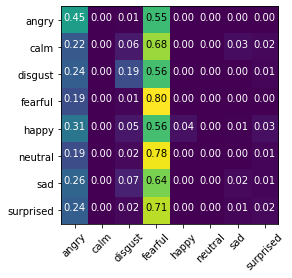

In [9]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

matrix = confusion_matrix(actual, predictions, normalize='true')

plt.imshow(matrix, interpolation="nearest")

target_names = lb.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)


thresh = matrix.max() / 1.5
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, "{:0.2f}".format(matrix[i, j]),
             horizontalalignment="center",
             color="white" if matrix[i, j] < thresh else "black")

In [ ]:
# TEST CODE, displays a video including the label, based on a sliding window mean
lb = pickle.loads(open("label_bin", "rb").read())

mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
size = 2
Q = deque(maxlen=size)

video_fn = "../data/dataset/02-01-02-01-18-30-720.mp4"
output_fn = "results/test.mp4"

vs = cv2.VideoCapture(video_fn)
writer = None
(W, H) = (None, None)

# Loop over video frames
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
        
    if W is None or H is None:
        (H, W) = frame.shape[:2]
        
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    
    preds = model.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    
    text = "emotion : {}".format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 5)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        # TODO: setup fps?
        writer = cv2.VideoWriter(output_fn, fourcc, 30, (W,H), True)
        
    writer.write(output)
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF
    
    
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

cv2.destroyWindow('Output')

writer.release()
vs.release()

    